In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import timeit
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs

In [2]:
# This code is to disable the qt backend and allow showing the figures in the notebook inline.

# Support inline plots
mne.viz.set_browser_backend('matplotlib')
%matplotlib inline

# Support pop up plots
#mne.viz.set_browser_backend('qt')
#%matplotlib qt


Using matplotlib as 2D backend.


In [3]:

#project directories
project_dir = os.getcwd()
mne.set_config('SUBJECTS_DIR',os.path.join(project_dir,'recons'))
data_dir = os.path.join(project_dir, 'rawMEGdata')
rawfile = os.path.join(data_dir,'subj04NN_sess01_raw_tsss.fif')
results_dir = os.path.join(project_dir,'results')

In [4]:
## Reject and flat criteria
reject = dict(mag=8000e-15, grad=8000e-13) # T, T/m
flat = dict(mag=1e-15, grad=1e-13)    #T/m

In [5]:

## Read raw file (cropped to speedup demo, keeps the first 1000 seconds)
raw = mne.io.read_raw_fif(rawfile, preload=False).crop(tmax=1000)

Opening raw data file f:\MYPROJECTS16\project_demoMNEpython\rawMEGdata\subj04NN_sess01_raw_tsss.fif...
    Range : 83000 ... 1705999 =     83.000 ...  1705.999 secs
Ready.
Opening raw data file f:\MYPROJECTS16\project_demoMNEpython\rawMEGdata\subj04NN_sess01_raw_tsss-1.fif...
    Range : 1706000 ... 3328999 =   1706.000 ...  3328.999 secs
Ready.
Opening raw data file f:\MYPROJECTS16\project_demoMNEpython\rawMEGdata\subj04NN_sess01_raw_tsss-2.fif...
    Range : 3329000 ... 4690999 =   3329.000 ...  4690.999 secs
Ready.


632 events found on stim channel STI101
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


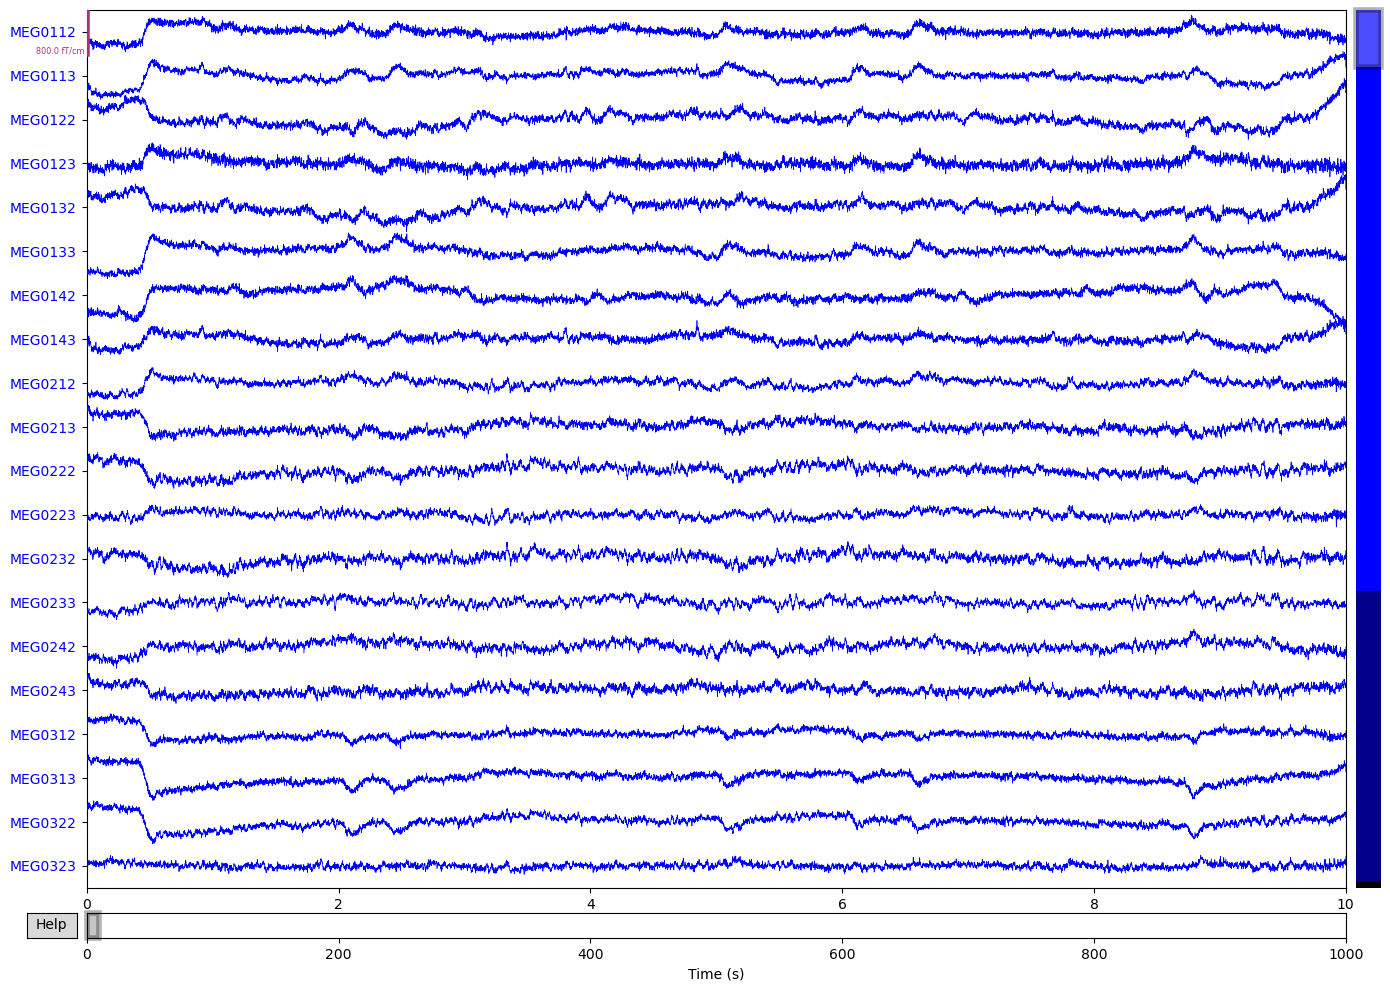

In [6]:

## Load events (use min_duration to avoid spurius events from the MEGIN device)
events = mne.find_events(raw, stim_channel='STI101',min_duration=0.002)
raw.plot(events=events, show=False)
plt.show()

Reading 0 ... 1000000  =      0.000 ...  1000.000 secs...
Including 0 SSP projectors from raw file
Running EOG SSP computation
Using EOG channel: MEG1411
EOG channel index for this subject is: [150]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel MEG1411 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 230 significant peaks
Number of EOG events detected: 230
Computing projector
Filtering raw data in 1 contiguous segment
Settin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   14.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   25.1s


Not setting metadata
230 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 230 events and 401 original time points ...
    Rejecting  epoch based on MAG : ['MEG1421']
    Rejecting  epoch based on MAG : ['MEG1421']
3 bad epochs dropped
Adding projection: planar--0.200-0.200-PCA-01 (exp var=97.0%)
Adding projection: axial--0.200-0.200-PCA-01 (exp var=98.7%)
No channels 'eeg' found. Skipping.
Done.
2 projection items deactivated


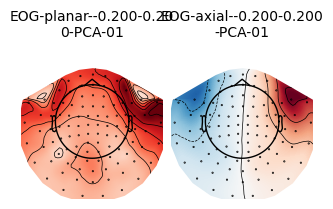

In [7]:

## Find eog (blink) projectors (EOG sensor not available, but MEG1411 is effective!)
eog_projs,eog_events = mne.preprocessing.compute_proj_eog(raw,ch_name='MEG1411',n_grad=1,n_mag=1,reject=reject,flat=flat)
raw.add_proj(eog_projs)
mne.viz.plot_projs_topomap(eog_projs,info=raw.info, show=False)
plt.show() #Use show=False and then plt.show() to prevent double screenshoots in notebook

In [8]:
# Create event_id dictionary
event_id = {}
for i in range(1,13):
    event_id['animate/human/body/{}'.format(i)] = i
for i in range(13,25):
    event_id['animate/human/face/{}'.format(i)] = i
for i in range(25,37):
    event_id['animate/animal/body/{}'.format(i)] = i
for i in range(37,49):
    event_id['animate/animal/face/{}'.format(i)] = i
for i in range(49,73):
    event_id['inanimate/natural/{}'.format(i)] = i
for i in range(73,93):
    event_id['inanimate/artificial/{}'.format(i)] = i


Not setting metadata
418 matching events found


Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Loading data for 418 events and 1001 original time points ...
0 bad epochs dropped


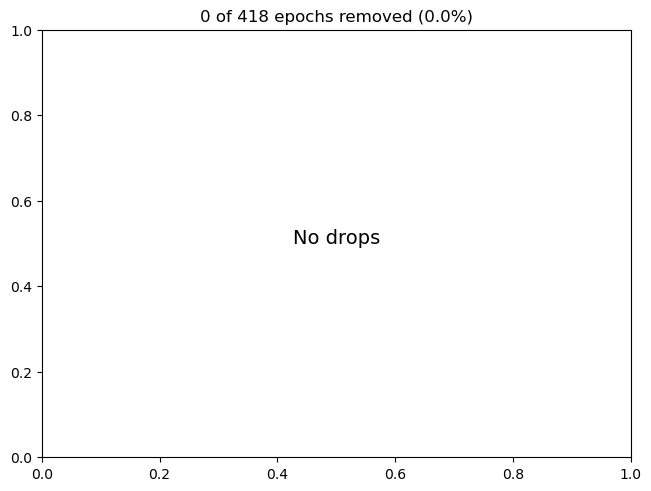

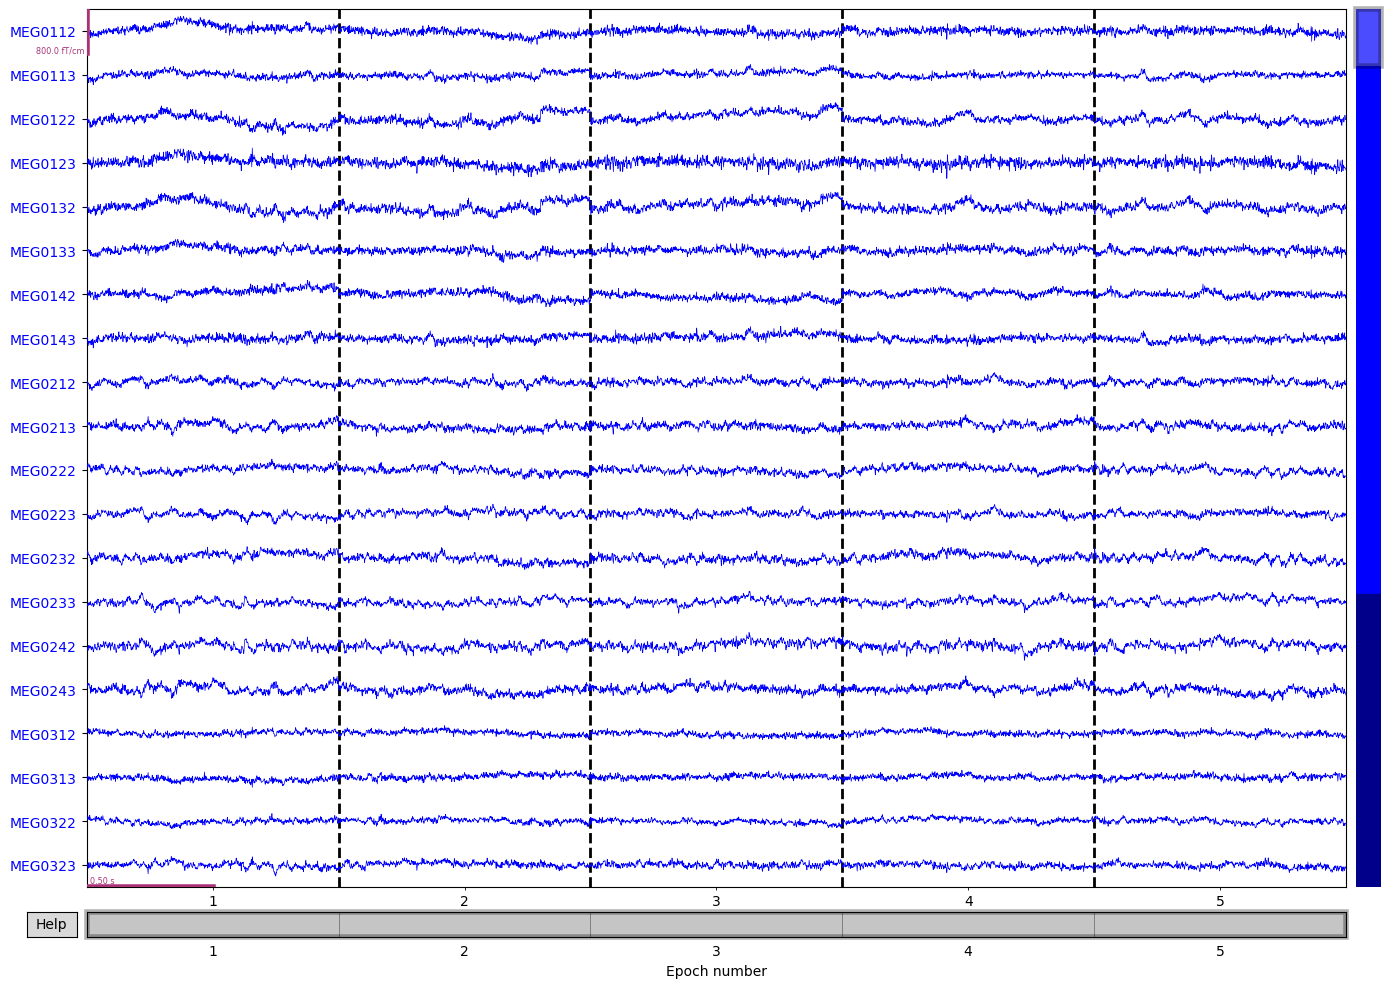

In [9]:
## Create epochs (baseline correction is applied automatically)
epochs = mne.Epochs(raw, events=events, event_id = event_id, tmin=-0.2, tmax=.8, reject=reject, flat=flat, reject_by_annotation=False, preload=True)
epochs.plot_drop_log() #only works if epochs loaded, e.g. preload=True
epochs[:5].plot(n_epochs=10, show=False)
plt.show()

In [10]:
# Downsample epochs to 250Hz
epochs = epochs.resample(250,n_jobs=10) 


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 202 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 9226 tasks      | elapsed:    6.0s
[Parallel(n_jobs=10)]: Done 26378 tasks      | elapsed:   11.7s
[Parallel(n_jobs=10)]: Done 108810 tasks      | elapsed:   19.8s
[Parallel(n_jobs=10)]: Done 128744 out of 128744 | elapsed:   21.3s finished


In [26]:
epochs

Number of events,418
Events,animate/animal/body/25: 6animate/animal/body/26: 6animate/animal/body/27: 5animate/animal/body/28: 4animate/animal/body/29: 4animate/animal/body/30: 4animate/animal/body/31: 6animate/animal/body/32: 4animate/animal/body/33: 5animate/animal/body/34: 4animate/animal/body/35: 5animate/animal/body/36: 4animate/animal/face/37: 6animate/animal/face/38: 5animate/animal/face/39: 5animate/animal/face/40: 5animate/animal/face/41: 4animate/animal/face/42: 5animate/animal/face/43: 4animate/animal/face/44: 4animate/animal/face/45: 5animate/animal/face/46: 4animate/animal/face/47: 4animate/animal/face/48: 5animate/human/body/1: 5animate/human/body/10: 4animate/human/body/11: 5animate/human/body/12: 4animate/human/body/2: 6animate/human/body/3: 4animate/human/body/4: 5animate/human/body/5: 5animate/human/body/6: 4animate/human/body/7: 4animate/human/body/8: 4animate/human/body/9: 4animate/human/face/13: 4animate/human/face/14: 5animate/human/face/15: 6animate/human/face/16: 5animate/human/face/17: 5animate/human/face/18: 4animate/human/face/19: 4animate/human/face/20: 5animate/human/face/21: 4animate/human/face/22: 4animate/human/face/23: 5animate/human/face/24: 6inanimate/artificial/73: 5inanimate/artificial/74: 5inanimate/artificial/75: 5inanimate/artificial/76: 4inanimate/artificial/77: 4inanimate/artificial/78: 4inanimate/artificial/79: 4inanimate/artificial/80: 4inanimate/artificial/81: 6inanimate/artificial/82: 4inanimate/artificial/83: 5inanimate/artificial/84: 4inanimate/artificial/85: 4inanimate/artificial/86: 4inanimate/artificial/87: 4inanimate/artificial/88: 5inanimate/artificial/89: 5inanimate/artificial/90: 4inanimate/artificial/91: 4inanimate/artificial/92: 4inanimate/natural/49: 4inanimate/natural/50: 4inanimate/natural/51: 5inanimate/natural/52: 6inanimate/natural/53: 4inanimate/natural/54: 6inanimate/natural/55: 4inanimate/natural/56: 4inanimate/natural/57: 4inanimate/natural/58: 4inanimate/natural/59: 5inanimate/natural/60: 5inanimate/natural/61: 4inanimate/natural/62: 4inanimate/natural/63: 4inanimate/natural/64: 4inanimate/natural/65: 4inanimate/natural/66: 5inanimate/natural/67: 4inanimate/natural/68: 5inanimate/natural/69: 4inanimate/natural/70: 5inanimate/natural/71: 4inanimate/natural/72: 4
Time range,-0.200 – 0.800 s
Baseline,-0.200 – 0.000 s


In [11]:
# Filter epochs, 35Hz low pass
epochs.filter(l_freq=None,h_freq=35, picks='meg')

Setting up low-pass filter at 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 95 samples (0.380 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.6s
[Parallel(n_job

Number of events,418
Events,animate/animal/body/25: 6animate/animal/body/26: 6animate/animal/body/27: 5animate/animal/body/28: 4animate/animal/body/29: 4animate/animal/body/30: 4animate/animal/body/31: 6animate/animal/body/32: 4animate/animal/body/33: 5animate/animal/body/34: 4animate/animal/body/35: 5animate/animal/body/36: 4animate/animal/face/37: 6animate/animal/face/38: 5animate/animal/face/39: 5animate/animal/face/40: 5animate/animal/face/41: 4animate/animal/face/42: 5animate/animal/face/43: 4animate/animal/face/44: 4animate/animal/face/45: 5animate/animal/face/46: 4animate/animal/face/47: 4animate/animal/face/48: 5animate/human/body/1: 5animate/human/body/10: 4animate/human/body/11: 5animate/human/body/12: 4animate/human/body/2: 6animate/human/body/3: 4animate/human/body/4: 5animate/human/body/5: 5animate/human/body/6: 4animate/human/body/7: 4animate/human/body/8: 4animate/human/body/9: 4animate/human/face/13: 4animate/human/face/14: 5animate/human/face/15: 6animate/human/face/16: 5animate/human/face/17: 5animate/human/face/18: 4animate/human/face/19: 4animate/human/face/20: 5animate/human/face/21: 4animate/human/face/22: 4animate/human/face/23: 5animate/human/face/24: 6inanimate/artificial/73: 5inanimate/artificial/74: 5inanimate/artificial/75: 5inanimate/artificial/76: 4inanimate/artificial/77: 4inanimate/artificial/78: 4inanimate/artificial/79: 4inanimate/artificial/80: 4inanimate/artificial/81: 6inanimate/artificial/82: 4inanimate/artificial/83: 5inanimate/artificial/84: 4inanimate/artificial/85: 4inanimate/artificial/86: 4inanimate/artificial/87: 4inanimate/artificial/88: 5inanimate/artificial/89: 5inanimate/artificial/90: 4inanimate/artificial/91: 4inanimate/artificial/92: 4inanimate/natural/49: 4inanimate/natural/50: 4inanimate/natural/51: 5inanimate/natural/52: 6inanimate/natural/53: 4inanimate/natural/54: 6inanimate/natural/55: 4inanimate/natural/56: 4inanimate/natural/57: 4inanimate/natural/58: 4inanimate/natural/59: 5inanimate/natural/60: 5inanimate/natural/61: 4inanimate/natural/62: 4inanimate/natural/63: 4inanimate/natural/64: 4inanimate/natural/65: 4inanimate/natural/66: 5inanimate/natural/67: 4inanimate/natural/68: 5inanimate/natural/69: 4inanimate/natural/70: 5inanimate/natural/71: 4inanimate/natural/72: 4
Time range,-0.200 – 0.796 s
Baseline,-0.200 – 0.000 s


In [12]:
# Save all epochs to avoid recomputing in subsequent scripts
epochs.save(os.path.join(project_dir,'data_tmp\\subj_{}-epo.fif'.format(0)), overwrite=True)

Overwriting existing file.
Overwriting existing file.


In [15]:
# Save noise covariance
#noise_cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose='error')
print(noise_cov)
noise_cov.save(os.path.join(project_dir,'data_tmp\\subj_{}-noise-cov.fif').format(0), overwrite=True)

<Covariance | kind : full, shape : (306, 306), range : [-1.9e-23, +3.6e-23], n_samples : 21317>
Overwriting existing file.


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 2.8e-13 (2.2e-16 eps * 306 dim * 4.1  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.8e-13 (2.2e-16 eps * 306 dim * 4.1  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
SSS has been applied to data. Showing mag and grad whitening jointly.
    Created an SSP operator (subspace dimension = 2)
Computing rank from covariance with rank={'meg': 304}


C:\Users\pantazis\AppData\Local\Temp\ipykernel_23648\1276544991.py:4: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  evoked.plot_white(noise_cov,time_unit='s', show=False)
C:\Users\pantazis\AppData\Local\Temp\ipykernel_23648\1276544991.py:4: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  evoked.plot_white(noise_cov,time_unit='s', show=False)


    Setting small MEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 304 (2 small eigenvalues omitted)


[]

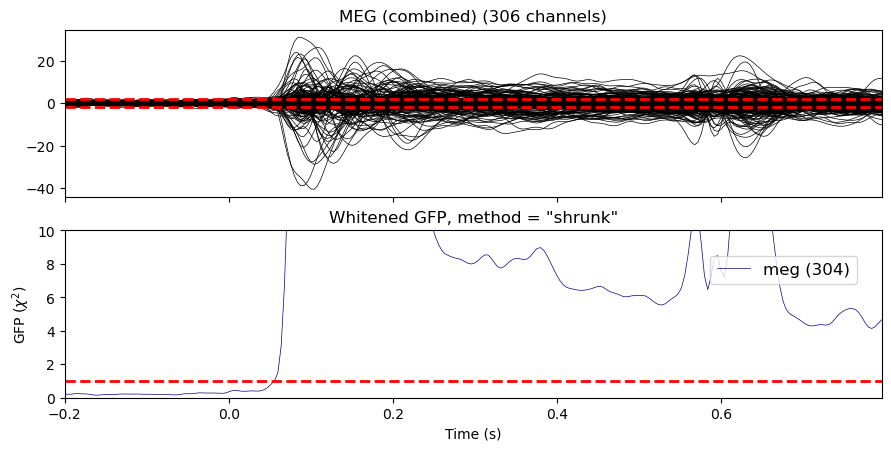

In [19]:
# Plot whitened evoked response
evoked = epochs.average()
#evoked.plot()
evoked.plot_white(noise_cov,time_unit='s', show=False)
plt.plot() 